In [ ]:
!pip3 install pydub
!pip3 install xmltodict
!pip3 install resemblyzer
!pip3 install pyannote.core
!pip3 install noisereduce
!pip3 install pyannote.metrics
!pip3 install python_speech_features
!pip3 install tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title
from pydub import AudioSegment
import xmltodict
import os
os.path.join('a','b')

from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

from operator import itemgetter
from lxml import etree
import xml.etree.ElementTree as ET
import json

import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio, display
from math import ceil

from pyannote.core import Segment, Timeline, Annotation, notebook
import noisereduce as nr
from tqdm import tqdm

from python_speech_features import fbank
from random import choice


In [ ]:
#@title
# Constants.

SAMPLE_RATE = 16000  # not higher than that otherwise we may have errors when computing the fbanks.

BATCH_SIZE = 32 * 3  # have to be a multiple of 3.

NUM_FRAMES = 160  
NUM_FBANKS = 64

# Preprocessing 

## VAD MODEL 1

In [ ]:
## parsing transcript xml file
def parse_ami_transcript_xml(file, speaker_id):
    """
    Parsing AMI transcript XML file
    """
    xmlp = ET.XMLParser(encoding="ISO-8859-1")
    f = ET.parse(file, parser=xmlp)
    root = f.getroot()
    transcript = []
    for element in list(root):
        if element.tag == 'w':
            if element.text:
                text = element.text
            else:
                text = ''
            if element.get('punc'):
                punc = True
            else:
                punc = False

            transcript.append({
                'start': float(element.get('starttime')),
                'end': float(element.get('endtime')),
                'text': text,
                'punc': punc,
                'speaker_id': speaker_id
            })
    previous = transcript[0]
    for index, elem in enumerate(transcript):
        if elem['start'] == previous['end']:
            previous['end'] = elem['end']
            previous['text'] += ('' if elem['punc'] else ' ') + elem['text']
            transcript[index] = None
        else:
            del elem['punc']
            previous = elem
    transcript = [t for t in transcript if t and len(t['text'])]
    return transcript

## Splitting wave file according to t1 and t2
def split_wav(directory_path,filename,t1,t2, chunk_id):
  t1=float(t1)*1000
  t2=float(t2)*1000
  complete_file_path = os.path.join(directory_path, filename)
  audio_file = AudioSegment.from_wav(complete_file_path)
  audio_file = audio_file[t1:t2]
  audio_file.export(complete_file_path.replace('.wav','')+f'_{chunk_id}.wav', format = 'wav')

## Parsing xml file
def parse_xml(directory_path, filename):
  complete_file_path = os.path.join(directory_path, filename)
  content = open(complete_file_path).read()
  return xmltodict.parse(content)

In [ ]:
#@title
## reading mfcc
def read_mfcc(input_filename, sample_rate):
    audio = Audio.read(input_filename, sample_rate)
    energy = np.abs(audio)
    silence_threshold = np.percentile(energy, 95)
    offsets = np.where(energy > silence_threshold)[0]
    
    # left_blank_duration_ms = (1000.0 * offsets[0]) // self.sample_rate  # frame_id to duration (ms)
    # right_blank_duration_ms = (1000.0 * (len(audio) - offsets[-1])) // self.sample_rate

    audio_voice_only = audio[offsets[0]:offsets[-1]]
    mfcc = mfcc_fbank(audio_voice_only, sample_rate)
    return mfcc


## Audio class for preprocessing
class Audio:

    def __init__(self, cache_dir: str, audio_dir: str = None, sample_rate: int = SAMPLE_RATE, ext='flac'):
        self.ext = ext
        self.cache_dir = os.path.join(cache_dir, 'audio-fbanks')
        ensures_dir(self.cache_dir)
        if audio_dir is not None:
            self.build_cache(os.path.expanduser(audio_dir), sample_rate)
        self.speakers_to_utterances = defaultdict(dict)
        for cache_file in find_files(self.cache_dir, ext='npy'):
            # /path/to/speaker_utterance.npy
            speaker_id, utterance_id = Path(cache_file).stem.split('_')
            self.speakers_to_utterances[speaker_id][utterance_id] = cache_file

    @property
    def speaker_ids(self):
        return sorted(self.speakers_to_utterances)

    @staticmethod
    def trim_silence(audio, threshold):
        """Removes silence at the beginning and end of a sample."""
        energy = librosa.feature.rms(audio)
        frames = np.nonzero(np.array(energy > threshold))
        indices = librosa.core.frames_to_samples(frames)[1]

        # Note: indices can be an empty array, if the whole audio was silence.
        audio_trim = audio[0:0]
        left_blank = audio[0:0]
        right_blank = audio[0:0]
        if indices.size:
            audio_trim = audio[indices[0]:indices[-1]]
            left_blank = audio[:indices[0]]  # slice before.
            right_blank = audio[indices[-1]:]  # slice after.
        return audio_trim, left_blank, right_blank

    @staticmethod
    def read(filename, sample_rate=SAMPLE_RATE):
        audio, sr = librosa.load(filename, sr=sample_rate, mono=True, dtype=np.float32)
        assert sr == sample_rate
        return audio

    def build_cache(self, audio_dir, sample_rate):
        logger.info(f'audio_dir: {audio_dir}.')
        logger.info(f'sample_rate: {sample_rate:,} hz.')
        audio_files = find_files(audio_dir, ext=self.ext)
        audio_files_count = len(audio_files)
        assert audio_files_count != 0, f'Could not find any {self.ext} files in {audio_dir}.'
        logger.info(f'Found {audio_files_count:,} files in {audio_dir}.')
        with tqdm(audio_files) as bar:
            for audio_filename in bar:
                bar.set_description(audio_filename)
                self.cache_audio_file(audio_filename, sample_rate)

    def cache_audio_file(self, input_filename, sample_rate):
        sp, utt = extract_speaker_and_utterance_ids(input_filename)
        cache_filename = os.path.join(self.cache_dir, f'{sp}_{utt}.npy')
        if not os.path.isfile(cache_filename):
            try:
                mfcc = read_mfcc(input_filename, sample_rate)
                np.save(cache_filename, mfcc)
            except librosa.util.exceptions.ParameterError as e:
                logger.error(e)


## padding mfcc
def pad_mfcc(mfcc, max_length):  # num_frames, nfilt=64.
    if len(mfcc) < max_length:
        mfcc = np.vstack((mfcc, np.tile(np.zeros(mfcc.shape[1]), (max_length - len(mfcc), 1))))
    return mfcc

## Generating fbanks and energies array
def mfcc_fbank(signal: np.array, sample_rate: int):  # 1D signal array.
    # Returns MFCC with shape (num_frames, n_filters, 3).
    filter_banks, energies = fbank(signal, samplerate=sample_rate, nfilt=NUM_FBANKS)
    frames_features = normalize_frames(filter_banks)
    # delta_1 = delta(filter_banks, N=1)
    # delta_2 = delta(delta_1, N=1)
    # frames_features = np.transpose(np.stack([filter_banks, delta_1, delta_2]), (1, 2, 0))
    return np.array(frames_features, dtype=np.float32)  # Float32 precision is enough here.


## Normalizing
def normalize_frames(m, epsilon=1e-12):
    return [(v - np.mean(v)) / max(np.std(v), epsilon) for v in m]

## sampling from mfcc
def sample_from_mfcc(mfcc, max_length):
    if mfcc.shape[0] >= max_length:
        r = choice(range(0, len(mfcc) - max_length + 1))
        s = mfcc[r:r + max_length]
    else:
        s = pad_mfcc(mfcc, max_length)
    return np.expand_dims(s, axis=-1)

## sampling from mfcc file
def sample_from_mfcc_file(utterance_file, max_length):
    mfcc = np.load(utterance_file)
    return sample_from_mfcc(mfcc, max_length)

In [ ]:
###################### PATH TO CORPUS & AUDIO FOLDER ######################
AMI_CORPUS_FOLDER = './drive/MyDrive/ATML/ami_public_manual_1.6.2/words'
AMI_AUDIO_FOLDER = './drive/MyDrive/ATML/amicorpus/'
AMI_AUDIO_FOLDER = './drive/MyDrive/amicorpus/'
AMI_AUDIO_FOLDER1 = './drive/MyDrive/amicorpusfinal/'
AMI_AUDIO_FOLDER2 = './drive/MyDrive/amicorpusfinal/'


SPEAKERS = ['A', 'B', 'C', 'D']
X_FILENAME = 'X_withoutEmbedding.txt'
Y_FILENAME = 'y.txt'
TIME_FILENAME = 'startEndTime.txt'

 


In [ ]:
import pickle

def write(list1,filename):
  l = list1
  with open(filename, "wb") as fp:   #Pickling
    pickle.dump(l, fp)

def read(filename):
  with open(filename, "rb") as fp:   # Unpickling
    b = pickle.load(fp)
  return b



```
# This is formatted as code
```


###Read Training Data


In [ ]:
#@title
WORKING_RECORDING_IDS = ['ES2002a','ES2004a','ES2005a','ES2006a','ES2007a','ES2009a','ES2010a','ES2011a','ES2012a','ES2006b','ES2007b','ES2009b','ES2010b','ES2011b','ES2012b']

def read_all(RECORDING_ID):
  X_withoutEmbedding = read(os.path.join(AMI_AUDIO_FOLDER1,RECORDING_ID,X_FILENAME))
  y = read(os.path.join(AMI_AUDIO_FOLDER1,RECORDING_ID,Y_FILENAME))
  startEndTime = read(os.path.join(AMI_AUDIO_FOLDER1,RECORDING_ID,TIME_FILENAME))
  return X_withoutEmbedding, y, startEndTime

def modifyTime(startEndTime):
  temp = [0]
  for i in range(1,len(startEndTime)):
    if(startEndTime[i][0]<startEndTime[i-1][0]):
      temp.append(temp[i-1]+startEndTime[i-1][1])
    else:
      temp.append(temp[i-1]) 
  for i in range(len(startEndTime)):
    startEndTime[i][0] = startEndTime[i][0] + temp[i] 
    startEndTime[i][1] = startEndTime[i][1] + temp[i]

  return temp

def createFinalList():
  X_withoutEmbedding, y, startEndTime = read_all(WORKING_RECORDING_IDS[0])

  

  for i in range(1,1):
    X_withoutEmbedding_temp, y_temp, startEndTime_temp = read_all(WORKING_RECORDING_IDS[i])
    ## modify y
    y_temp = [n + 4*i for n in y_temp]
    ## modify startEndTime
    temp = modifyTime(startEndTime)
    

    X_withoutEmbedding.extend(X_withoutEmbedding_temp)
    y.extend(y_temp)
    startEndTime.extend(startEndTime_temp)

  return X_withoutEmbedding, y, startEndTime

X_withoutEmbedding, y, startEndTime = createFinalList()
print(len(X_withoutEmbedding),len(y),len(startEndTime))

448 448 448


In [ ]:
!pip install webrtcvad
import contextlib
import numpy as np
import wave
import librosa
import webrtcvad

# Reading wave file
def read_wave(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

# Frame class
class Frame(object):
  def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

# generating frame for given duration and audio
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n

def vad_collector(vad, frames, sample_rate):
    is_speech = []
    for frame in frames:
        is_speech.append(vad.is_speech(frame.bytes, sample_rate))
    return is_speech

# generating segments, used to seperate noise from speech
def vad(file):
    audio, sample_rate = read_wave(file)
    vad = webrtcvad.Vad(2)
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    segments = vad_collector(vad, frames, sample_rate)
    return segments

# checking if given chunk contain voice or not, according to threshold limit
def speech(file,threshold):
  dummy = 0
  data = []
  segments = vad(file)
  # audio, sr = librosa.load(file)
  # print(segments.count(True)/len(segments))
  if(threshold > segments.count(True)/len(segments)):
    return False
  return True

# return time segment of voice part from complete wav file
def fxn(file):
  segments = vad(file)
  segments = np.asarray(segments)
  
  dummy = 0.01*np.where(segments[:-1] != segments[1:])[0] +.01 
  print(segments,(segments[:-1] != segments[1:]).tolist().count(True))
  if len(dummy)%2==0:
    dummy = dummy
  else:
    dummy = np.delete(dummy, len(dummy)-1)
  print(len(dummy))
  voice = dummy.reshape(int(len(dummy)/2),2)
  
  return voice

# return time segment of voice part from complete wav file
def allSegments(file):
  dummy = 0
  data = []
  startEndTime = []
  segments = vad(file)
  print(segments.count(True)/len(segments))
  for i in range(1,len(segments)):
    if(segments[i]):
      if(len(startEndTime)==0):
        startEndTime.append([i*10/1000,(i*10+10)/1000])
      else:
        if(segments[i-1]):
          startEndTime[-1][1]= (i*10+10)/1000
        else:
          startEndTime.append([i*10/1000,(i*10+10)/1000])
        
  return startEndTime


def split_wav_test(directory_path,filename,t1,t2, chunk_id,threshold):
  t1=float(t1)*1000
  t2=float(t2)*1000
  complete_file_path = os.path.join(directory_path, filename)
  
  audio_file = AudioSegment.from_wav(complete_file_path)
  audio_file = audio_file[t1:t2]
  audio_file.export(complete_file_path.replace('.wav','')+f'_{chunk_id}.wav', format = 'wav')
  isVoise = speech(complete_file_path.replace('.wav','')+f'_{chunk_id}.wav',threshold)
  return isVoise

In [ ]:
file = './drive/MyDrive/amicorpusfinal/ES2002a/audio/ES2002a.Mix-Headset.wav'

startEndTimeTemp1 =  fxn(file)
yTemp1 = [1 for i in range(len(startEndTimeTemp1))]


## VAD Model 2

In [ ]:

import numpy as np
import scipy.io.wavfile as wf
import matplotlib.pyplot as plt

class VoiceActivityDetector():
    """ Use signal energy to detect voice activity in wav file """
    
    def __init__(self, wave_input_filename):
        self._read_wav(wave_input_filename)._convert_to_mono()
        self.sample_window = 0.02 #20 ms
        self.sample_overlap = 0.01 #10ms
        self.speech_window = 0.5 #half a second
        self.speech_energy_threshold = 0.6 #60% of energy in voice band
        self.speech_start_band = 300
        self.speech_end_band = 3000
           
    def _read_wav(self, wave_file):
        self.rate, self.data = wf.read(wave_file)
        self.channels = len(self.data.shape)
        self.filename = wave_file
        return self
    
    def _convert_to_mono(self):
        if self.channels == 2 :
            self.data = np.mean(self.data, axis=1, dtype=self.data.dtype)
            self.channels = 1
        return self
    
    def _calculate_frequencies(self, audio_data):
        data_freq = np.fft.fftfreq(len(audio_data),1.0/self.rate)
        data_freq = data_freq[1:]
        return data_freq    
    
    def _calculate_amplitude(self, audio_data):
        data_ampl = np.abs(np.fft.fft(audio_data))
        data_ampl = data_ampl[1:]
        return data_ampl
        
    def _calculate_energy(self, data):
        data_amplitude = self._calculate_amplitude(data)
        data_energy = data_amplitude ** 2
        return data_energy
        
    def _znormalize_energy(self, data_energy):
        energy_mean = np.mean(data_energy)
        energy_std = np.std(data_energy)
        energy_znorm = (data_energy - energy_mean) / energy_std
        return energy_znorm
    
    def _connect_energy_with_frequencies(self, data_freq, data_energy):
        energy_freq = {}
        for (i, freq) in enumerate(data_freq):
            if abs(freq) not in energy_freq:
                energy_freq[abs(freq)] = data_energy[i] * 2
        return energy_freq
    
    def _calculate_normalized_energy(self, data):
        data_freq = self._calculate_frequencies(data)
        data_energy = self._calculate_energy(data)
        #data_energy = self._znormalize_energy(data_energy) #znorm brings worse results
        energy_freq = self._connect_energy_with_frequencies(data_freq, data_energy)
        return energy_freq
    
    def _sum_energy_in_band(self,energy_frequencies, start_band, end_band):
        sum_energy = 0
        for f in energy_frequencies.keys():
            if start_band<f<end_band:
                sum_energy += energy_frequencies[f]
        return sum_energy
    
    def _median_filter (self, x, k):
        assert k % 2 == 1, "Median filter length must be odd."
        assert x.ndim == 1, "Input must be one-dimensional."
        k2 = (k - 1) // 2
        y = np.zeros ((len (x), k), dtype=x.dtype)
        y[:,k2] = x
        for i in range (k2):
            j = k2 - i
            y[j:,i] = x[:-j]
            y[:j,i] = x[0]
            y[:-j,-(i+1)] = x[j:]
            y[-j:,-(i+1)] = x[-1]
        return np.median (y, axis=1)
        
    def _smooth_speech_detection(self, detected_windows):
        median_window=int(self.speech_window/self.sample_window)
        if median_window%2==0: median_window=median_window-1
        median_energy = self._median_filter(detected_windows[:,1], median_window)
        return median_energy
        
    def convert_windows_to_readible_labels(self, detected_windows):
        """ Takes as input array of window numbers and speech flags from speech
        detection and convert speech flags to time intervals of speech.
        Output is array of dictionaries with speech intervals.
        """
        speech_time = []
        is_speech = 0
        for window in detected_windows:
            if (window[1]==1.0 and is_speech==0): 
                is_speech = 1
                speech_label = {}
                speech_time_start = window[0] / self.rate
                speech_label['speech_begin'] = speech_time_start
                print(window[0], speech_time_start)
                #speech_time.append(speech_label)
            if (window[1]==0.0 and is_speech==1):
                is_speech = 0
                speech_time_end = window[0] / self.rate
                speech_label['speech_end'] = speech_time_end
                speech_time.append(speech_label)
                print(window[0], speech_time_end)
        return speech_time
      
    def plot_detected_speech_regions(self):
        """ Performs speech detection and plot original signal and speech regions.
        """
        data = self.data
        detected_windows = self.detect_speech()
        data_speech = np.zeros(len(data))
        it = np.nditer(detected_windows[:,0], flags=['f_index'])
        while not it.finished:
            data_speech[int(it[0])] = data[int(it[0])] * detected_windows[it.index,1]
            it.iternext()
        plt.figure()
        plt.plot(data_speech)
        plt.plot(data)
        plt.show()
        return self
       
    def detect_speech(self):
        """ Detects speech regions based on ratio between speech band energy
        and total energy.
        Output is array of window numbers and speech flags (1 - speech, 0 - nonspeech).
        """
        detected_windows = np.array([])
        sample_window = int(self.rate * self.sample_window)
        sample_overlap = int(self.rate * self.sample_overlap)
        data = self.data
        sample_start = 0
        start_band = self.speech_start_band
        end_band = self.speech_end_band
        while (sample_start < (len(data) - sample_window)):
            sample_end = sample_start + sample_window
            if sample_end>=len(data): sample_end = len(data)-1
            data_window = data[sample_start:sample_end]
            energy_freq = self._calculate_normalized_energy(data_window)
            sum_voice_energy = self._sum_energy_in_band(energy_freq, start_band, end_band)
            sum_full_energy = sum(energy_freq.values())
            speech_ratio = sum_voice_energy/sum_full_energy
            # Hipothesis is that when there is a speech sequence we have ratio of energies more than Threshold
            speech_ratio = speech_ratio>self.speech_energy_threshold
            detected_windows = np.append(detected_windows,[sample_start, speech_ratio])
            sample_start += sample_overlap
        detected_windows = detected_windows.reshape(int(len(detected_windows)/2),2)
        detected_windows[:,1] = self._smooth_speech_detection(detected_windows)
        return detected_windows
 

startEndTime_vad2 =  VoiceActivityDetector(file)
startEndTime_vad2.plot_detected_speech_regions()

In [ ]:
startEndTimeTemp2 =  startEndTime_vad2.detect_speech()

In [ ]:
yTemp2 = [1 for i in range(len(startEndTimeTemp2))]

In [ ]:
vad2_start_end = startEndTime_vad2.convert_windows_to_readible_labels(startEndTimeTemp2)

59680.0 3.73
60960.0 3.81
276480.0 17.28
278720.0 17.42
285760.0 17.86
292000.0 18.25
415520.0 25.97
420960.0 26.31
431840.0 26.99
432640.0 27.04
620320.0 38.77
624000.0 39.0
770400.0 48.15
770560.0 48.16
890080.0 55.63
892320.0 55.77
953280.0 59.58
954880.0 59.68
1236160.0 77.26
1240640.0 77.54
1241280.0 77.58
1241600.0 77.6
1243520.0 77.72
1246240.0 77.89
1251360.0 78.21
1254720.0 78.42
2030400.0 126.9
2032000.0 127.0
2520000.0 157.5
2526400.0 157.9
2556320.0 159.77
2560960.0 160.06
2849760.0 178.11
2849920.0 178.12
3095680.0 193.48
3096000.0 193.5
3457600.0 216.1
3460320.0 216.27
3480800.0 217.55
3481760.0 217.61
3658080.0 228.63
3665920.0 229.12
4271040.0 266.94
4273600.0 267.1
4421120.0 276.32
4424320.0 276.52
4579040.0 286.19
4580160.0 286.26
4600480.0 287.53
4602720.0 287.67
4652640.0 290.79
4657600.0 291.1
4676800.0 292.3
4678240.0 292.39
4997760.0 312.36
5002880.0 312.68
5010400.0 313.15
5015200.0 313.45
5017600.0 313.6
5021440.0 313.84
5041440.0 315.09
5043200.0 315.2
5121760

### Der calculation

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate, GreedyDiarizationErrorRate, JaccardErrorRate

def get_hypothesis(speaker_segments):
    hypothesis = Annotation()
    for t in speaker_segments:
        try:
            hypothesis[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_hyp"
        except:
            pass
        
    return hypothesis

def get_ref(speaker_segments):
    reference = Annotation()
    for t in speaker_segments:
        try:
            reference[Segment(t['start'], t['end'])] = f"{t['speaker_id']}_ref"
        except:
            pass
        
    return reference

der = DiarizationErrorRate()
gder = GreedyDiarizationErrorRate()
jer = JaccardErrorRate()

def measure_metrics(reference, hypothesis):
    der_value = der(reference, hypothesis)
    print('DER:', der_value)

    
    return der_value

In [ ]:
def ref_hypo(startEndTime,startEndTime_ref,labels,y):
  speaker_segments = []
  for i in range(len(startEndTime)):
    speaker_segments.append({
                        'start': startEndTime[i][0],
                        'end': startEndTime[i][1],
                        'speaker_id': labels[i]
                    })
  speaker_segments_ref = []
  for i in range(len(startEndTime_ref)):
    speaker_segments_ref.append({
                        'start': startEndTime_ref[i][0],
                        'end': startEndTime_ref[i][1],
                        'speaker_id': y[i]
                    })
  return speaker_segments,speaker_segments_ref

In [ ]:
y = [1 for i in range(len(startEndTime))]
speaker_segments,speaker_segments_ref = ref_hypo(startEndTimeTemp2,startEndTime,yTemp2,y)
hypothesis = get_hypothesis(speaker_segments)
reference = get_ref(speaker_segments_ref)
der_value = measure_metrics(reference, hypothesis)

DER: 1.0


/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


In [ ]:
print(yTemp1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
## reading wave file
rate, data = wf.read(file) 

In [ ]:
temp_vad = []

for i in range(len(vad2_start_end)):
  temp_vad.append([vad2_start_end[i]['speech_begin'], vad2_start_end[i]['speech_end']])



In [ ]:
startEndTimeTemp2 = np.array(temp_vad)

In [ ]:
## assigning 0 to non speech part
def mod_signal(data, startEndTime):

    vad_signal = np.array(data)

    # print(vad_signal)


    prev = 0
    
    for i in range(len(startEndTime)):

      next = startEndTime[i][0]

      vad_signal[int(rate * prev): int(rate * next) - 1] = 0

      prev = startEndTime[i][1]


    return vad_signal



ground_signal = mod_signal(data, startEndTime)

vad1_signal = mod_signal(data, startEndTimeTemp1)


vad2_signal = mod_signal(data, startEndTimeTemp2)




# Plots

## Original wave signal

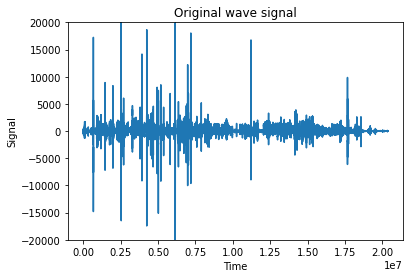

In [ ]:
plt.title("Original wave signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.ylim(-20000,20000)
plt.plot(data)
plt.savefig('/content/drive/MyDrive/plots/OriginalWaveSignal.png')


## Ground Truth wave signal

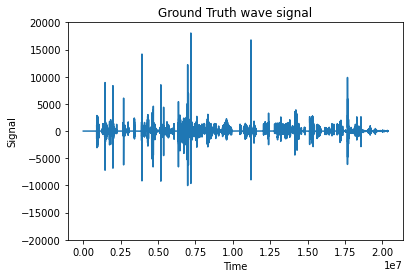

In [ ]:
plt.title("Ground Truth wave signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.ylim(-20000,20000)
plt.plot(ground_signal, label="ground_signal")
plt.savefig('/content/drive/MyDrive/plots/GroundTruthWaveSignal.png')


## VAD (webrtcvad) Model 1 wave signal

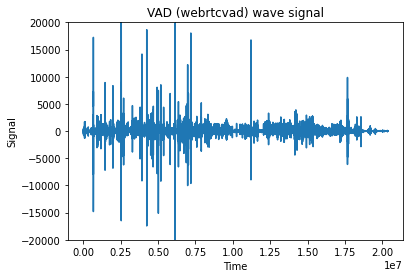

In [ ]:
plt.title("VAD (webrtcvad) wave signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.ylim(-20000,20000)
plt.plot(vad1_signal, label="vad1_signal")
plt.savefig('/content/drive/MyDrive/plots/vad1WaveSignal.png')


## VAD Model 2 wave signal

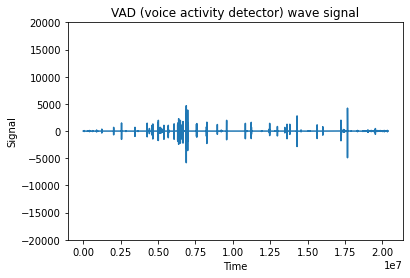

In [ ]:
plt.title("VAD (voice activity detector) wave signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.ylim(-20000,20000)
plt.plot(vad2_signal, label="vad2_signal")
plt.savefig('/content/drive/MyDrive/plots/vad2WaveSignal.png')

In [ ]:
print(startEndTimeTemp2)
print(startEndTimeTemp1)

[[   3.73    3.81]
 [  17.28   17.42]
 [  17.86   18.25]
 [  25.97   26.31]
 [  26.99   27.04]
 [  38.77   39.  ]
 [  48.15   48.16]
 [  55.63   55.77]
 [  59.58   59.68]
 [  77.26   77.54]
 [  77.58   77.6 ]
 [  77.72   77.89]
 [  78.21   78.42]
 [ 126.9   127.  ]
 [ 157.5   157.9 ]
 [ 159.77  160.06]
 [ 178.11  178.12]
 [ 193.48  193.5 ]
 [ 216.1   216.27]
 [ 217.55  217.61]
 [ 228.63  229.12]
 [ 266.94  267.1 ]
 [ 276.32  276.52]
 [ 286.19  286.26]
 [ 287.53  287.67]
 [ 290.79  291.1 ]
 [ 292.3   292.39]
 [ 312.36  312.68]
 [ 313.15  313.45]
 [ 313.6   313.84]
 [ 315.09  315.2 ]
 [ 320.11  320.3 ]
 [ 321.58  321.78]
 [ 322.56  322.61]
 [ 326.6   326.66]
 [ 328.93  329.06]
 [ 330.32  330.35]
 [ 332.1   332.48]
 [ 332.89  333.14]
 [ 333.64  333.76]
 [ 335.08  335.18]
 [ 336.79  337.4 ]
 [ 354.8   354.86]
 [ 355.    355.47]
 [ 356.67  356.8 ]
 [ 379.6   379.85]
 [ 394.65  394.97]
 [ 396.81  397.2 ]
 [ 398.73  398.99]
 [ 401.36  401.7 ]
 [ 405.69  405.84]
 [ 408.    408.12]
 [ 408.85  4

# VAD LSTM Trained Model 3

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import keras.layers as layers


def map_data(data, label):
    return (data, label)



## Model Defined

In [ ]:
model = keras.Sequential()

model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Flatten())
model.add(layers.Dense(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.build(input_shape=(None, 59, 44))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 59, 256)           177152    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 59, 256)           394240    
_________________________________________________________________
dense (Dense)                (None, 59, 32)            8224      
_________________________________________________________________
dense_1 (Dense)              (None, 59, 32)            1056      
_________________________________________________________________
flatten (Flatten)            (None, 1888)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                60448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [ ]:
model.load_weights("/content/drive/MyDrive/YashVAD/LSTM_keras_50epochs_VAD_BEST_MODEL_Flatten_MIN_LOSS_ADEM.h5")

## Creating input vector for Model

In [ ]:
# VAD data read
X_FILENAME_VAD = 'X_VAD.txt'
Y_FILENAME_VAD = 'y_VAD.txt'
TIME_FILENAME_VAD = 'startEndTime_VAD.txt'

TRAIN_WORKING_RECORDING_IDS = ['IS1000b', 'IS1001b', 'IS1002b', 'IS1003b', 'IS1004b', 'IS1005b', 'IS1006b', 
                               'TS3003b', 'TS3004b', 'TS3005b', 'TS3006b', 'TS3007b', 'TS3008b', 'TS3009b',
                               'ES2002a', 'ES2004a', 'ES2005a', 'ES2006a', 'ES2006b', 'ES2007a', 'ES2009a']



VAL_WORKING_RECORDING_IDS = ['IS1007b', 'IS1008b',
                             'TS3010b', 'TS3011b',
                             'ES2010a', 'ES2011a']

TEST_WORKING_RECORDING_IDS = [ 'IS1009b',
                              'TS3012b',
                              'ES2012a']


def read_all_VAD(RECORDING_ID,AMI_AUDIO_FOLDER,threshold):
  def BinaryY(y,threshold):
    for i in range(len(y)):
      if(y[i]>=threshold):
        y[i]=1
      else:
        y[i]=0
  X = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,X_FILENAME_VAD))
  y = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,Y_FILENAME_VAD))
  BinaryY(y,threshold)
  startEndTime = read(os.path.join(AMI_AUDIO_FOLDER,RECORDING_ID,TIME_FILENAME_VAD))
  return X, y, startEndTime

X_withoutEmbedding, y, startEndTime = read_all_VAD(TRAIN_WORKING_RECORDING_IDS[14],AMI_AUDIO_FOLDER2,0.25)
X_withoutEmbedding_test, y_test, startEndTime_test = read_all_VAD(TEST_WORKING_RECORDING_IDS[0],AMI_AUDIO_FOLDER2,0.25)

In [ ]:
train_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding, y)) 
train_dataset_embedding = train_dataset_embedding.batch(32)
train_dataset_embedding = train_dataset_embedding.map(map_data)


test_dataset_embedding = tf.data.Dataset.from_tensor_slices((X_withoutEmbedding_test, y_test)) 
test_dataset_embedding = test_dataset_embedding.batch(32)
test_dataset_embedding = test_dataset_embedding.map(map_data)

In [ ]:
train_embeddings_tl, train_labels_tl = model.predict(train_dataset_embedding), y
test_embeddings_tl, test_labels_tl = model.predict(test_dataset_embedding), y_test


x1 = [1 if i>.5 else 0 for i in train_embeddings_tl]
x2 = [1 if i>.5 else 0 for i in test_embeddings_tl]

In [ ]:
X, y = np.array(x1), np.array([int(i) for i in train_labels_tl])
X_test, y_test =  np.array(x2), np.array([int(i) for i in test_labels_tl])

In [ ]:
speaker_segments,speaker_segments_ref = ref_hypo(startEndTime,startEndTime,X,y)
speaker_segments_test,speaker_segments_ref_test = ref_hypo(startEndTime_test,startEndTime_test,X_test,y_test)

## Der calculation

In [ ]:
hypothesis = get_hypothesis(speaker_segments)
reference = get_ref(speaker_segments_ref)
der_value = measure_metrics(reference, hypothesis)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.18474842767295596


In [ ]:
hypothesis_test = get_hypothesis(speaker_segments_test)
reference_test = get_ref(speaker_segments_ref_test)
der_value = measure_metrics(reference_test, hypothesis_test)

/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


DER: 0.05458089668615984


## Ploting Noise removed Audio

In [ ]:
startEndTimeTemp3 = []
for i in range(len(startEndTime)):
  if(X[i]==1):
    startEndTimeTemp3.append([startEndTime[i][0]+0.01,startEndTime[i][1]])

In [ ]:
vad3_signal = mod_signal(data, startEndTimeTemp3)

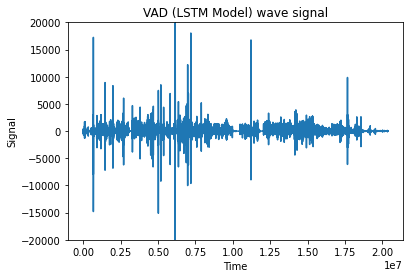

In [ ]:
plt.title("VAD (LSTM Model) wave signal")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.ylim(-20000,20000)
plt.plot(vad3_signal, label="vad3_signal")
plt.savefig('/content/drive/MyDrive/plots/vad3WaveSignal.png')